In [1]:
######################################     Modules     #######################################
# MODULES
import sys
from time import process_time
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact

sys.path.append('../.')
import verbose_module
sys.path.append('../../../.')
import pIRPgym

path = '/Users/juanbeta/My Drive/Research/Supply Chain Analytics/pIRPgym/'
experiments_path = '/Users/juanbeta/My Drive/Research/Supply Chain Analytics/Experiments/First Phase/'

Experiments = [i for i in range(1,6)]
Replicas = {i:[j for j in range(1,6)] for i in range(1,5)}
Replicas.update({5:[1,2,3]})


alphas = [0.1,0.2,0.4,0.6,0.8]
time_limits = [1,30,60,300,1800,3600]

init_times = {1:0.1,30:1,60:3,300:5,1800:5,3600:10}
Sizes = {1:5,2:10,3:15,4:20,5:40,6:60}

Policies = ['MIP','NN','RCL']+[f'CG_{time_limit}_' for time_limit in time_limits]+\
           [f'CG_{time_limit}__{alpha}' for time_limit in time_limits for alpha in alphas]

def find_best_performance(experiment,replica):
    Results = list()
    start = 0 if experiment <= 2 else 1
    
    results = dict()
    for policy in Policies[start:]:
        with open(experiments_path+f'Experiment {experiment}/Replica {replica}/{policy}.pkl','rb') as file:
                results[policy] = pickle.load(file)

    for t in range(len(results['NN'])):
        min_cost = 1e9 
        for policy in Policies[start:]:
            loc = 1 if policy!='RCL' else 0
            obj = results[policy][t][loc] 
            if obj < min_cost:
                min_cost = obj
        Results.append(min_cost)
    
    return Results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11


# Visualization by Experiment

In [2]:
def plot_experiment_result(experiments,policies,indicator,runtime):
    policies = list(policies)
    policies+=[f'CG_{runtime}_']+[f'CG_{runtime}__{alpha}' for alpha in alphas]
    
    sizes = {experiment:Sizes[experiment] for experiment in experiments}

    E_x_values = [f'Exp{exp} (M/K={size})' for exp,size in sizes.items()]

    Experiments_results = {('Instance','M/K'):[Sizes[experiment] for experiment in experiments]}
    Experiments_results.update({(policy,item):list() for policy in policies for item in ['eff','gaps']})

    for experiment in experiments:

        reliability = {policy:[] for policy in policies}
        gaps = {policy:[] for policy in policies}

        for replica in Replicas[experiment]:
            with open(experiments_path+f'Experiment {experiment}/Replica {replica}/instance_information.pkl', 'rb') as file:
                inst_info = pickle.load(file)

            results = dict()
            for policy in policies:
                with open(experiments_path+f'Experiment {experiment}/Replica {replica}/{policy}.pkl','rb') as file:
                    results[policy] = pickle.load(file)

            best_performances = find_best_performance(experiment,replica)
            for t in range(inst_info['inst_gen'].T):
                best_performance = best_performances[t]
                
                for policy in policies:
                    loc = 1 if policy!='RCL' else 0
                    
                    if (results[policy][t][loc] - best_performance)/best_performance < 0.01:
                        reliability[policy].append(1)
                    else:
                        reliability[policy].append(0)
                        gaps[policy].append((results[policy][t][loc]-best_performance)/best_performance)

        # Storing the results
        for policy in policies:
                Experiments_results[(policy,'eff')].append(round(sum(reliability[policy])/len(reliability[policy]),4))
                if len(gaps[policy]) > 0:
                    Experiments_results[(policy,'gaps')].append(round(sum(gaps[policy])/len(gaps[policy]),4))
                else:
                    Experiments_results[(policy,'gaps')].append(0)


    print('\n')
    df = pd.DataFrame(Experiments_results)
    df.index = experiments
    df = df.style.format(dict.fromkeys(list(df.columns)[1:],"{:.2%}"))
    display(df)

    print('\n')
    E_results = dict()
    for policy in policies:
        E_results[policy] ={'effectiveness':Experiments_results[str(policy),'eff'],'gap':Experiments_results[str(policy),'gaps']} 
    
    pIRPgym.Visualizations.RoutingV.plot_metric(E_results,indicator,x_axis='Experiments',x_values=E_x_values)

interact(plot_experiment_result,
         experiments = widgets.SelectMultiple(options=Experiments,value=Experiments,rows=5,description='Experiments:'),
         policies=widgets.SelectMultiple(options=['MIP','NN','RCL'],value=['NN','RCL'],rows=3,description='Policies:'),
         indicator=widgets.Dropdown(options=['effectiveness','gap'],value='effectiveness',description='Indicator:'),
         runtime=widgets.Dropdown(options=[1,30,60,300,1800,3600],value=1,description='CG run time:'))

interactive(children=(SelectMultiple(description='Experiments:', index=(0, 1, 2, 3, 4), options=(1, 2, 3, 4, 5…

<function __main__.plot_experiment_result(experiments, policies, indicator, runtime)>

# Visualization by Supplier Number


In [3]:
def plot_supplier_num_results(experiments,policies,indicator,display_range,runtime):
    policies = list(policies)
    policies+=[f'CG_{runtime}_']+[f'CG_{runtime}__{alpha}' for alpha in alphas]

    Suppliers_results = {('Instance','M/K'):[],('Instance','Number'):[]}
    Suppliers_results.update({(policy,item):[] for policy in policies for item in ['eff','gaps']})

    reliability = {policy:dict() for policy in policies}
    gaps = {policy:dict() for policy in policies}

    for experiment in experiments:
        for replica in Replicas[experiment]:
            # Upload results
            with open(experiments_path+f'Experiment {experiment}/Replica {replica}/instance_information.pkl', 'rb') as file:
                inst_info = pickle.load(file)

            results = dict()
            for policy in policies: 
                with open(experiments_path+f'Experiment {experiment}/Replica {replica}/{policy}.pkl', 'rb') as file:
                    results[policy] = pickle.load(file)

            
            best_performances = find_best_performance(experiment,replica)
            # For each day determine the best score
            for t in range(inst_info['inst_gen'].T):
                num_suppliers = len([node for route in results['NN'][t][0] for node in route if node != 0])
                if num_suppliers not in reliability['NN'].keys():
                    for policy in policies:
                        reliability[policy][num_suppliers] = list()
                        gaps[policy][num_suppliers] = list()

                best_performance = best_performances[t]

                for policy in policies: 
                    pos = 1 if policy != 'RCL' else 0
                    if (results[policy][t][pos] - best_performance)/best_performance < 0.01:
                        reliability[policy][num_suppliers].append(1)
                    else:
                        reliability[policy][num_suppliers].append(0)
                        gaps[policy][num_suppliers].append((results[policy][t][pos]-best_performance)/best_performance)

                        

    # Storing the results
    supplier_categories = sorted(list(set(reliability[policies[0]].keys())))
    Suppliers_results[('Instance','M/K')] = supplier_categories

    for sup_num in supplier_categories:
        Suppliers_results[('Instance','Number')].append(len(reliability["NN"][sup_num]))


        for policy in policies:
            Suppliers_results[(str(policy),'eff')].append(round(sum(reliability[policy][sup_num])/len(reliability[policy][sup_num]),4))
            if len(gaps[policy][sup_num]) > 0:
                Suppliers_results[(str(policy),'gaps')].append(round(sum(gaps[policy][sup_num])/len(gaps[policy][sup_num]),4))
            else:
                Suppliers_results[(str(policy),'gaps')].append(0)

    print('\n')
    df = pd.DataFrame(Suppliers_results)
    df.index = supplier_categories
    # df.columns = ['M/K','Regular', 'al 0.1','al 0.2','al 0.4','al 0.6']
    df = df.style.format(dict.fromkeys(list(df.columns)[2:],"{:.2%}"))
    display(df)

    results = dict()
    for policy in policies:
        results[policy] = {'effectiveness':Suppliers_results[policy,'eff']}
        results[policy].update({'gaps':Suppliers_results[policy,'gaps']})

    display_num_suppliers = list()
    display_results = dict()
    for policy in policies:
        display_results[policy] = {'effectiveness':list()}
        display_results[policy].update({'gap':list()})

    for i,num in enumerate(supplier_categories):
        if num >= display_range[0] and num <= display_range[1]:
            display_num_suppliers.append(num)
            for policy in policies:
                display_results[policy]['effectiveness'].append(results[policy]['effectiveness'][i])
                display_results[policy]['gap'].append(results[policy]['gaps'][i])

    print('\n')
    pIRPgym.Visualizations.RoutingV.plot_metric(display_results,indicator,x_axis='# Suppliers',
                                                             x_values=display_num_suppliers)

interact(plot_supplier_num_results,
         experiments = widgets.SelectMultiple(options=Experiments,value=Experiments,rows=5,description='Experiments'),
         policies=widgets.SelectMultiple(options=['MIP','NN','RCL'],value=['NN'],rows=3,description='Policies:'),
         indicator=widgets.Dropdown(options=['effectiveness','gap'],value='effectiveness',description='Indicator:'),
         display_range=widgets.IntRangeSlider(  value=[1,30],min=1,max=40,step=1,
                                                description='# Suppliers:',continuous_update=False,
                                                orientation='horizontal',readout=True,
                                                readout_format='d'),
         runtime=widgets.Dropdown(options=[1,30,60,300,1800,3600],value=1,description='CG run time:'))

interactive(children=(SelectMultiple(description='Experiments', index=(0, 1, 2, 3, 4), options=(1, 2, 3, 4, 5)…

<function __main__.plot_supplier_num_results(experiments, policies, indicator, display_range, runtime)>

# Visualization by Replica

In [4]:
def plot_replica_results(experiment,replica,runtime):
    if experiment <= 2:
        policies = ['MIP','NN','RCL',f'CG_{runtime}']+[f'CG_{runtime}_{alpha}' for alpha in alphas]
    else:
        policies = ['NN','RCL',f'CG_{runtime}']+[f'CG_{runtime}_{alpha}' for alpha in alphas]

    Replica_results = {('Instance','Step'):[],('Instance','# Suppliers'):[]}
    # Replica_results.update({(policy,'gap'):[] for policy in policies})
    # Replica_results.update({(policy,item):[] for policy in policies[-6:] for item in ['RCL_cols','CG_cols']})

    gaps = {policy:[] for policy in policies}
    RCL_cols = {policy:[] for policy in policies[-6:]}
    CG_cols = {policy:[] for policy in policies[-6:]}

    # Upload results
    with open(experiments_path+f'Experiment {experiment}/Replica {replica}/instance_information.pkl', 'rb') as file:
            inst_info = pickle.load(file)

    R_results = dict()
    for policy in policies:
            with open(experiments_path+f'Experiment {experiment}/Replica {replica}/{policy}.pkl', 'rb') as file:
                    R_results[policy] = pickle.load(file)

    best_performances = find_best_performance(experiment,replica)
    for t in range(inst_info['inst_gen'].T):
        Replica_results[('Instance','Step')].append(t+1)
        Replica_results[('Instance','# Suppliers')].append(len(inst_info["Requirements"][t]))

        best_performance = best_performances[t]

        for policy in policies:
            loc = 1 if policy!='RCL' else 0
            
            if (R_results[policy][t][loc] - best_performance)/best_performance < 0.01:
                gaps[policy].append(0)
            else:
                gaps[policy].append((R_results[policy][t][loc]-best_performance)/best_performance)
            
            if policy[:3]=='CG_':
                RCL_cols[policy].append(R_results[policy][t][4][0])
                CG_cols[policy].append(R_results[policy][t][4][1])

    R_x_values = [f'{t} ({len(inst_info["Requirements"][t])})' for t in range(inst_info['inst_gen'].T)]

    RR_results = dict()

    for policy in policies:
        Replica_results[(policy,'gap')] = gaps[policy]
        RR_results[policy] = {'gap':Replica_results[policy,'gap']} 
        if policy[:3]=='CG_':
            Replica_results[(policy,'RCL_cols')] = RCL_cols[policy]
            Replica_results[(policy,'CG_cols')] = CG_cols[policy]
       
    print('\n')
    df = pd.DataFrame(Replica_results)

    if experiment <= 2:
        df = df.style.format(dict.fromkeys([list(df.columns)[j] for j in [2,3,4,5,8,11,14,17,20]],"{:.2%}"))
    else:
         df = df.style.format(dict.fromkeys([list(df.columns)[j] for j in [2,3,4,7,10,13,16,19]],"{:.2%}"))
    display(df)
    print('\n')
    pIRPgym.Visualizations.RoutingV.plot_indicator_evolution(RR_results,'gap',x_axis='Steps',x_values=R_x_values)


interact(plot_replica_results,
         experiment=widgets.Dropdown(options=[i for i in range(1,6)],value=1,description='Experiment:'),
         replica=widgets.Dropdown(options=[i for i in range(1,6)],value=1,description='Replica:'),
         runtime=widgets.Dropdown(options=[1,30,60,300,1800,3600],value=1,description='CG run time:'))


interactive(children=(Dropdown(description='Experiment:', options=(1, 2, 3, 4, 5), value=1), Dropdown(descript…

<function __main__.plot_replica_results(experiment, replica, runtime)>

# Visualization of Columns

In [16]:
Policies = [f'CG_{time_limit}_' for time_limit in time_limits]+\
           [f'CG_{time_limit}__{alpha}' for time_limit in time_limits for alpha in alphas]
results = {policy:[[],[]] for policy in Policies}


for experiment in Experiments:
    for replica in Replicas[experiment]:
        # Upload results
        with open(experiments_path+f'Experiment {experiment}/Replica {replica}/instance_information.pkl', 'rb') as file:
                inst_info = pickle.load(file)

        for time_limit in time_limits:
            policy = f'CG_{time_limit}_'

            with open(experiments_path+f'Experiment {experiment}/Replica {replica}/{policy}.pkl', 'rb') as file:
                res = pickle.load(file)
            
            results[policy][0].append(res[t][4][0])
            results[policy][1].append(res[t][4][1])

            for alpha in alphas:
                policy = f'CG_{time_limit}__{alpha}'
                with open(experiments_path+f'Experiment {experiment}/Replica {replica}/{policy}.pkl', 'rb') as file:
                    res = pickle.load(file)
                    
                for t in range(inst_info['inst_gen'].T):
                    results[policy][0].append(res[t][4][0])
                    results[policy][1].append(res[t][4][1])



for time_limit in time_limits:
    policy = f'CG_{time_limit}_'
    results[policy][0] = sum(results[policy][0])/len(results[policy][0])
    results[policy][1] = sum(results[policy][1])/len(results[policy][1])
    for alpha in alphas:
        policy = f'CG_{time_limit}__{alpha}'
        results[policy][0] = sum(results[policy][0])/len(results[policy][0])
        results[policy][1] = sum(results[policy][1])/len(results[policy][1])

In [17]:
results

{'CG_1_': [0.0, 40.78260869565217],
 'CG_30_': [0.0, 72.30434782608695],
 'CG_60_': [0.0, 75.56521739130434],
 'CG_300_': [0.0, 84.82608695652173],
 'CG_1800_': [0.0, 87.95652173913044],
 'CG_3600_': [0.0, 87.95652173913044],
 'CG_1__0.1': [45.42028985507246, 20.02173913043478],
 'CG_1__0.2': [176.41666666666666, 14.322463768115941],
 'CG_1__0.4': [452.786231884058, 9.652173913043478],
 'CG_1__0.6': [609.0615942028985, 8.576086956521738],
 'CG_1__0.8': [700.8369565217391, 8.532608695652174],
 'CG_30__0.1': [78.3586956521739, 40.177536231884055],
 'CG_30__0.2': [600.8369565217391, 26.855072463768117],
 'CG_30__0.4': [1543.5942028985507, 15.876811594202898],
 'CG_30__0.6': [2443.539855072464, 13.746376811594203],
 'CG_30__0.8': [2946.06884057971, 15.326086956521738],
 'CG_60__0.1': [88.32608695652173, 41.721014492753625],
 'CG_60__0.2': [880.5507246376811, 28.18840579710145],
 'CG_60__0.4': [2728.18115942029, 16.253623188405797],
 'CG_60__0.6': [4158.916666666667, 13.789855072463768],
 '

In [13]:
res[0][4]

(0, 16)

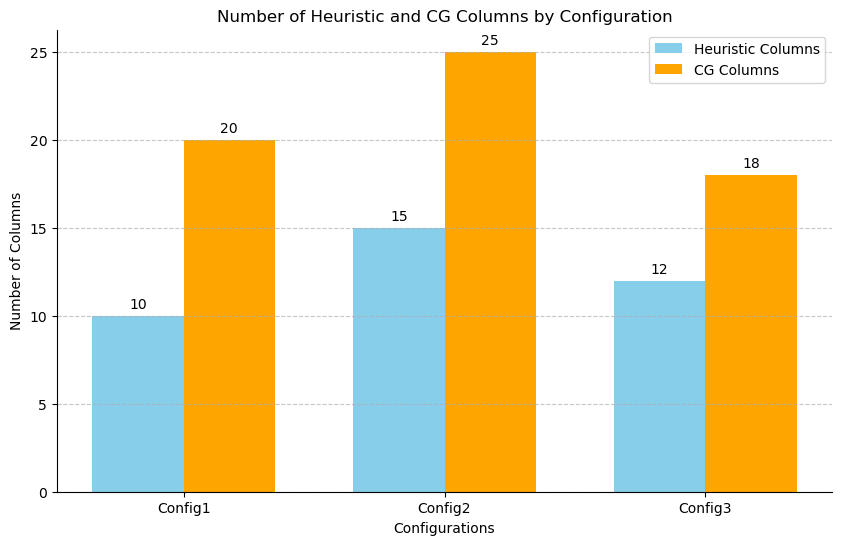

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_column_generation_results(results_dict):
    """
    Plot the number of heuristic and CG columns for different configurations.

    Parameters:
    - results_dict (dict): A dictionary with configurations as keys and lists (heuristic columns, CG columns) as values.

    Returns:
    None
    """
    # Extract data for plotting
    configurations = list(results_dict.keys())
    heuristic_columns = [item[0] for item in results_dict.values()]
    cg_columns = [item[1] for item in results_dict.values()]

    # Set up positions for bars on x-axis
    x = np.arange(len(configurations))

    # Bar width
    width = 0.35

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10, 6))
    bar1 = ax.bar(x - width/2, heuristic_columns, width, label='Heuristic Columns', color='skyblue')
    bar2 = ax.bar(x + width/2, cg_columns, width, label='CG Columns', color='orange')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels, title, and legend
    ax.set_xlabel('Configurations')
    ax.set_ylabel('Number of Columns')
    ax.set_title('Number of Heuristic and CG Columns by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(configurations)
    ax.legend()

    # Display the values on top of the bars
    for bar in [bar1, bar2]:
        for rect in bar:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Show the plot
    plt.show()

# Example usage:
results_dict = {'Config1': [10, 20], 'Config2': [15, 25], 'Config3': [12, 18]}
plot_column_generation_results(results_dict)


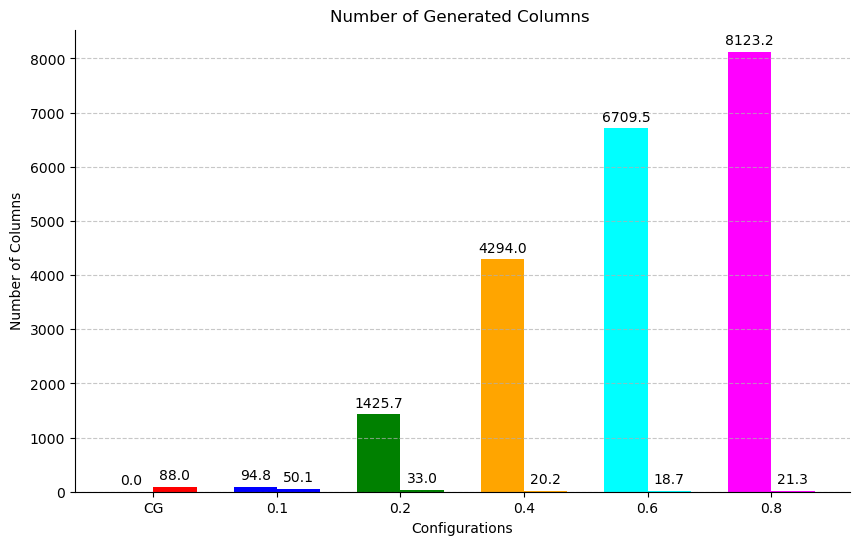

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_column_generation_results(results_dict):
    """
    Plot the number of heuristic and CG columns for different configurations.

    Parameters:
    - results_dict (dict): A dictionary with configurations as keys and lists (heuristic columns, CG columns) as values.

    Returns:
    None
    """
    # Extract data for plotting
    configurations = list(results_dict.keys())
    heuristic_columns = [item[0] for item in results_dict.values()]
    cg_columns = [item[1] for item in results_dict.values()]

    # Set up positions for bars on x-axis
    x = np.arange(len(configurations))

    # Bar width
    width = 0.35

    # Plotting the bars with unique colors for each configuration
    fig, ax = plt.subplots(figsize=(10, 6))
    bar1 = ax.bar(x - width/2, heuristic_columns, width=width, label='Heuristic Columns',
                    edgecolor='black',linewidth=0)
    bar2 = ax.bar(x + width/2, cg_columns, width=width, label='CG Columns',
                    edgecolor='black',linewidth=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Assigning unique colors to each configuration
    # color_cycle = plt.cm.get_cmap('tab10', len(configurations))
    color_cycle = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta','black','brown']
    for i, (bar1_rect, bar2_rect) in enumerate(zip(bar1, bar2)):
        bar1_rect.set_color(color_cycle[i])
        bar2_rect.set_color(color_cycle[i])

    # Add labels, title, and legend
    ax.set_xlabel('Configurations')
    ax.set_ylabel('Number of Columns')
    ax.set_title('Number of Generated Columns ')
    ax.set_xticks(x)
    ax.set_xticklabels(configurations)
    # ax.legend()

    # Display the values on top of the bars
    for bar in [bar1, bar2]:
        for rect in bar:
            height = rect.get_height()
            ax.annotate(f'{round(height,1)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Show the plot
    plt.show()

# Example usage:
data = {'CG': [0.0, 40.78260869565217],
        '0.1': [45.42028985507246, 20.02173913043478],
        '0.2': [176.41666666666666, 14.322463768115941],
        '0.4': [452.786231884058, 9.652173913043478],
        '0.6': [609.0615942028985, 8.576086956521738],
        '0.8': [700.8369565217391, 8.532608695652174]}

data2 = {   'CG': [0.0, 87.95652173913044],
            '0.1': [94.78260869565217, 50.06521739130435],
            '0.2': [1425.6884057971015, 33.04347826086956],
            '0.4': [4294.018115942029, 20.235507246376812],
            '0.6': [6709.54347826087, 18.681159420289855],
            '0.8': [8123.184782608696, 21.282608695652176]}

plot_column_generation_results(data2)


/var/folders/m6/89fwm0dn5mjbdz4tkj6586bm0000gn/T/ipykernel_88636/4210780135.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('tab10', len(configurations))
/var/folders/m6/89fwm0dn5mjbdz4tkj6586bm0000gn/T/ipykernel_88636/4210780135.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(configurations)


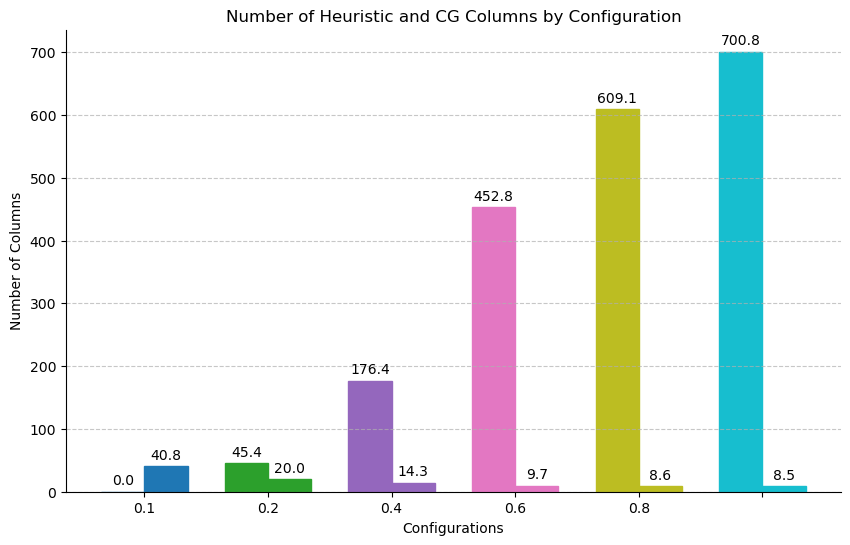